In [113]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from src import MPNN
from src.systems import HarmonicOscillator, PoschlTeller
from src.utils import energy

## Random Sampling

### Harmonic Oscillator

In [131]:
dim = 1
order = [2]
mass = 1
omega = 1
domains = [[-5, 5]]
oscillator = HarmonicOscillator(order=order, dim=dim, mass=mass, omega=omega, domains=domains)
x = torch.linspace(-5., 5., 50).view(-1, 1, 1)

In [132]:
model = MPNN(
    in_size=dim,
    out_scaling=12.5,
    delta=0.01,
    final_act='sigmoid'
)

model.load_state_dict(torch.load('/Users/Ameya/code/Quantum-Potential-Prediction/saved-models/harmonic1d-random.pth'))
model.eval()

MPNN(
  (layer1): Linear(in_features=1, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=1, bias=True)
)

In [133]:
E_pot_pred = model(x)
E_pot_true = torch.tensor([oscillator.potential(i) for i in x])
_ , psi, Hpsi = energy(oscillator, x, E_pot_pred)
E_tot_pred = Hpsi / psi.squeeze()
E_tot_true = torch.ones(50) * 2.5

In [139]:
xis = [xi.requires_grad_() for xi in x.flatten(start_dim=1).t()]
xs_flat = torch.stack(xis, dim=1)
psi = oscillator.wavefunction(xs_flat.view_as(x))
(dpsi_dxs, ) = torch.autograd.grad(psi, xs_flat, torch.ones_like(psi), create_graph=True)
laplacian = sum(
    torch.autograd.grad(
        dpsi_dxi, xi, torch.ones_like(dpsi_dxi), retain_graph=True, create_graph=False
    )[0]
    for xi, dpsi_dxi in zip(xis, (dpsi_dxs[..., i] for i in range(len(xis))))
)

E_tot_pred = ((-0.5 * laplacian)/ psi.squeeze()) + E_pot_pred.squeeze()
E_tot_true = torch.ones(50) * 2.5

Text(0, 0.5, 'Potential Energy (V)')

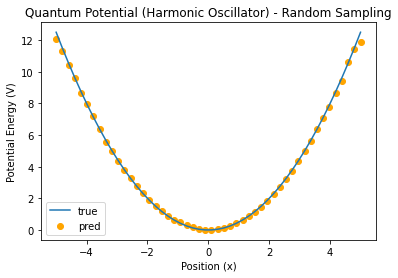

In [88]:
plt.scatter(x.squeeze().detach().numpy(), E_pot_pred.squeeze().detach().numpy(), label='pred', color='orange')
plt.plot(x.squeeze().detach().numpy(), E_pot_true.squeeze().detach().numpy(), label='true')
plt.legend()
plt.title('Quantum Potential (Harmonic Oscillator) - Random Sampling')
plt.xlabel('Position (x)')
plt.ylabel('Potential Energy (V)')

Text(0, 0.5, 'Total Energy (E)')

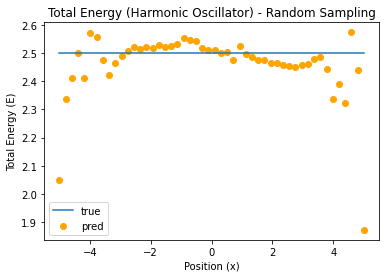

In [140]:
plt.scatter(x.squeeze().detach().numpy(), E_tot_pred.squeeze().detach().numpy(), label='pred', color='orange')
plt.plot(x.squeeze().detach().numpy(), E_tot_true.squeeze().detach().numpy(), label='true')
plt.legend()
plt.title('Total Energy (Harmonic Oscillator) - Random Sampling')
plt.xlabel('Position (x)')
plt.ylabel('Total Energy (E)')

### Poschl-Teller System

In [114]:
dim = 1
domains = [[-3, 3]]
pt = PoschlTeller(dim=dim, domain=domains)
x = torch.linspace(-3., 3., 50, requires_grad=True).view(-1, 1, 1)

In [96]:
model = MPNN(
    in_size=dim,
    out_scaling=1,
    delta=1
)

model.load_state_dict(torch.load('/Users/Ameya/code/Quantum-Potential-Prediction/saved-models/pt1d.pth'))
model.eval()

MPNN(
  (layer1): Linear(in_features=1, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=1, bias=True)
)

In [97]:
E_pot_pred = model(x)
E_pot_true = torch.tensor([pt.potential(i) for i in x])

In [126]:
xis = [xi.requires_grad_() for xi in x.flatten(start_dim=1).t()]
xs_flat = torch.stack(xis, dim=1)
psi = ((torch.abs(torch.tanh(xs_flat.view_as(x)))) * (1 / torch.cosh(xs_flat.view_as(x))))
(dpsi_dxs, ) = torch.autograd.grad(psi, xs_flat, torch.ones_like(psi), create_graph=True)
laplacian = sum(
    torch.autograd.grad(
        dpsi_dxi, xi, torch.ones_like(dpsi_dxi), retain_graph=True, create_graph=False
    )[0]
    for xi, dpsi_dxi in zip(xis, (dpsi_dxs[..., i] for i in range(len(xis))))
)

E_tot_pred = ((-0.5 * laplacian)/ psi.squeeze()) + E_pot_pred.squeeze()
E_tot_true = torch.ones(50) * -0.5

Text(0, 0.5, 'Potential Energy (V)')

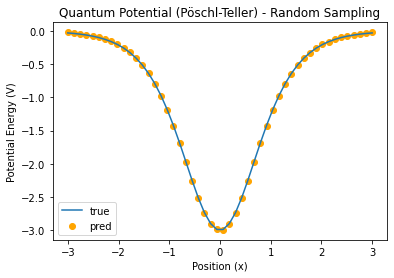

In [99]:
plt.scatter(x.squeeze().detach().numpy(), E_pot_pred.squeeze().detach().numpy(), label='pred', color='orange')
plt.plot(x.squeeze().detach().numpy(), E_pot_true.squeeze().detach().numpy(), label='true')
plt.legend()
plt.title('Quantum Potential (Pöschl-Teller) - Random Sampling')
plt.xlabel('Position (x)')
plt.ylabel('Potential Energy (V)')

Text(0, 0.5, 'Total Energy (E)')

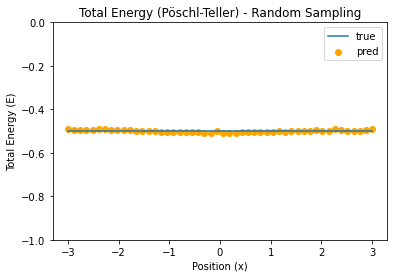

In [130]:
plt.scatter(x.squeeze().detach().numpy(), E_tot_pred.squeeze().detach().numpy(), label='pred', color='orange')
plt.plot(x.squeeze().detach().numpy(), E_tot_true.squeeze().detach().numpy(), label='true')
plt.legend()
plt.ylim(-1., 0.)
plt.title('Total Energy (Pöschl-Teller) - Random Sampling')
plt.xlabel('Position (x)')
plt.ylabel('Total Energy (E)')

## Metropolis Sampling

In [8]:
model = MPNN(
    in_size=dim,
    out_scaling=12.5,
    delta=0.01
)

model.load_state_dict(torch.load('/Users/Ameya/code/Quantum-Potential-Prediction/saved-models/harmonic1d-metropolis.pth'))
model.eval()

MPNN(
  (layer1): Linear(in_features=1, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=1, bias=True)
)

In [9]:
E_pot_pred = model(x)
E_pot_true = torch.tensor([oscillator.potential(i) for i in x])
_ , psi, Hpsi = energy(oscillator, x, E_pot_pred)
E_tot_pred = Hpsi / psi.squeeze()
E_tot_true = torch.ones(50) * 2.5

Text(0, 0.5, 'Potential Energy (V)')

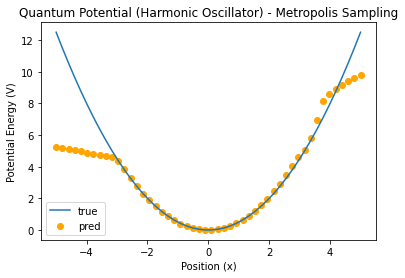

In [10]:
plt.scatter(x.squeeze().detach().numpy(), E_pot_pred.squeeze().detach().numpy(), label='pred', color='orange')
plt.plot(x.squeeze().detach().numpy(), E_pot_true.squeeze().detach().numpy(), label='true')
plt.legend()
plt.title('Quantum Potential (Harmonic Oscillator) - Metropolis Sampling')
plt.xlabel('Position (x)')
plt.ylabel('Potential Energy (V)')

Text(0, 0.5, 'Total Energy (E)')

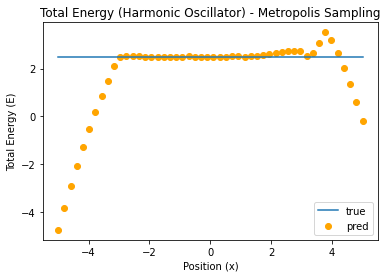

In [11]:
plt.scatter(x.squeeze().detach().numpy(), E_tot_pred.squeeze().detach().numpy(), label='pred', color='orange')
plt.plot(x.squeeze().detach().numpy(), E_tot_true.squeeze().detach().numpy(), label='true')
plt.legend()
plt.title('Total Energy (Harmonic Oscillator) - Metropolis Sampling')
plt.xlabel('Position (x)')
plt.ylabel('Total Energy (E)')

### Poschl-Teller

In [141]:
dim = 1
domains = [[-3, 3]]
pt = PoschlTeller(dim=dim, domain=domains)
x = torch.linspace(-3., 3., 50, requires_grad=True).view(-1, 1, 1)

In [143]:
model = MPNN(
    in_size=dim,
    out_scaling=1,
    delta=1
)

model.load_state_dict(torch.load('/Users/Ameya/code/Quantum-Potential-Prediction/saved-models/pt1d-metropolis.pth'))
model.eval()

MPNN(
  (layer1): Linear(in_features=1, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=1, bias=True)
)

In [144]:
E_pot_pred = model(x)
E_pot_true = torch.tensor([pt.potential(i) for i in x])

In [145]:
xis = [xi.requires_grad_() for xi in x.flatten(start_dim=1).t()]
xs_flat = torch.stack(xis, dim=1)
psi = ((torch.abs(torch.tanh(xs_flat.view_as(x)))) * (1 / torch.cosh(xs_flat.view_as(x))))
(dpsi_dxs, ) = torch.autograd.grad(psi, xs_flat, torch.ones_like(psi), create_graph=True)
laplacian = sum(
    torch.autograd.grad(
        dpsi_dxi, xi, torch.ones_like(dpsi_dxi), retain_graph=True, create_graph=False
    )[0]
    for xi, dpsi_dxi in zip(xis, (dpsi_dxs[..., i] for i in range(len(xis))))
)

E_tot_pred = ((-0.5 * laplacian)/ psi.squeeze()) + E_pot_pred.squeeze()
E_tot_true = torch.ones(50) * -0.5

Text(0, 0.5, 'Potential Energy (V)')

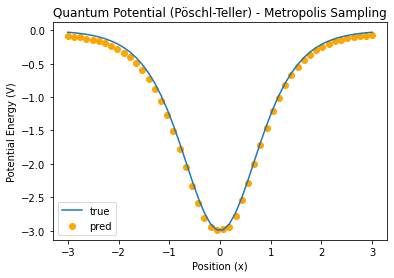

In [146]:
plt.scatter(x.squeeze().detach().numpy(), E_pot_pred.squeeze().detach().numpy(), label='pred', color='orange')
plt.plot(x.squeeze().detach().numpy(), E_pot_true.squeeze().detach().numpy(), label='true')
plt.legend()
plt.title('Quantum Potential (Pöschl-Teller) - Metropolis Sampling')
plt.xlabel('Position (x)')
plt.ylabel('Potential Energy (V)')

Text(0, 0.5, 'Total Energy (E)')

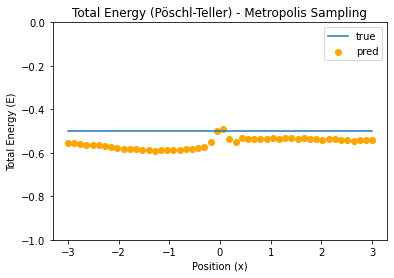

In [147]:
plt.scatter(x.squeeze().detach().numpy(), E_tot_pred.squeeze().detach().numpy(), label='pred', color='orange')
plt.plot(x.squeeze().detach().numpy(), E_tot_true.squeeze().detach().numpy(), label='true')
plt.legend()
plt.ylim(-1., 0.)
plt.title('Total Energy (Pöschl-Teller) - Metropolis Sampling')
plt.xlabel('Position (x)')
plt.ylabel('Total Energy (E)')